In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

<h2>Use CUDA</h2>

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# use_cuda = torch.cuda.is_available()
use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [4]:
from common import SubprocVecEnv

num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

<h2>Neural Network</h2>

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = F.softmax(self.actor(x))
        dist  = Categorical(probs)
        return dist, value

    def get_logits(self, x):
        logits = self.actor(x)
        return logits[:, 1] - logits[:, 0]

In [6]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    all_states = []
    all_actions = []
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        all_states.append(state)

        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        all_actions.append(action)

        next_state, reward, done, _ = env.step(action)
        state = next_state
        if vis:
            env.render()
        total_reward += reward
    return total_reward, all_states, all_actions

<h1>A2C: Synchronous Advantage Actor Critic</h1>
<h3><a href="https://blog.openai.com/baselines-acktr-a2c/#a2canda3c">OpenAI Blog:</a></h3>
<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

In [7]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [8]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
model.load_state_dict(torch.load('cartpole.dqn.pt', map_location='cpu'))

<All keys matched successfully>

In [37]:
test_env(True)

/tmp/ipykernel_4225/1861009698.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.actor(x))


(200.0,
 [tensor([[ 0.0131, -0.0351, -0.0108, -0.0172]]),
  tensor([[ 0.0124,  0.1602, -0.0111, -0.3133]]),
  tensor([[ 0.0156, -0.0348, -0.0174, -0.0241]]),
  tensor([[ 0.0149,  0.1606, -0.0179, -0.3222]]),
  tensor([[ 0.0181, -0.0343, -0.0243, -0.0352]]),
  tensor([[ 0.0174,  0.1612, -0.0250, -0.3355]]),
  tensor([[ 0.0206, -0.0336, -0.0317, -0.0508]]),
  tensor([[ 0.0200,  0.1620, -0.0327, -0.3533]]),
  tensor([[ 0.0232,  0.3576, -0.0398, -0.6561]]),
  tensor([[ 0.0303,  0.1630, -0.0529, -0.3762]]),
  tensor([[ 0.0336, -0.0313, -0.0604, -0.1007]]),
  tensor([[ 0.0330,  0.1646, -0.0625, -0.4118]]),
  tensor([[ 0.0363, -0.0296, -0.0707, -0.1395]]),
  tensor([[ 0.0357, -0.2236, -0.0735,  0.1301]]),
  tensor([[ 0.0312, -0.0275, -0.0709, -0.1848]]),
  tensor([[ 0.0307,  0.1686, -0.0746, -0.4990]]),
  tensor([[ 0.0340, -0.0254, -0.0846, -0.2307]]),
  tensor([[ 0.0335, -0.2193, -0.0892,  0.0341]]),
  tensor([[ 0.0291, -0.0230, -0.0885, -0.2853]]),
  tensor([[ 0.0287, -0.2167, -0.0942, -0.0

In [9]:
max_frames   = 20000
frame_idx    = 0
test_rewards = []

In [31]:
all_rewards, all_states, all_actions = [], [], []
from tqdm.notebook import tqdm
for _ in tqdm(range(1000)):
    # roll out level
    reward, states, actions = test_env(False)

    all_rewards.append(reward)
    all_states.extend(states)
    all_actions.extend(actions)
    
all_states = torch.concat(all_states, dim=0)
all_states.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_4225/1861009698.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.actor(x))


torch.Size([187225, 4])

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -0.418 rad (-24&deg;) | ~ 0.418 rad (24&deg;)
3 | Pole Velocity At Tip | -Inf | Inf

In [32]:
class Perturber:
    def __init__(self, std_scale=2e-2):
        self.std_scale = std_scale
        self.max_state = torch.tensor([2.4, 2.4, .418, 1.5])

    def perturb(self, state):
        """
        State has (x, v, theta, omega)
        These values can't exceed (2.4, 2.4, 0.418, 1.5)
        as seen from the rollouts

        For each value, we look at distance to boundary
        for x=2.3, distance to boundary is 0.1
        perturbation for x ~ N(0, 0.1 * self.std_scale)
        
        for omega=-1.25, distance to boundary is 0.25
        perturbation for omega ~ N(0, 0.2 * self.std_scale)
        and so on

        position_saliency = (model_out - model_out_for_perturbed_position) / perturbation_for_position
        omega_saliency = (model_out - model_out_for_perturbed_omega) / perturbation_for_omega
        and so on
        """
        dist_to_left = torch.abs(state + self.max_state)
        dist_to_right = torch.abs(self.max_state - state)
        min_distance = torch.vstack([dist_to_left, dist_to_right]).min(0).values
        std = min_distance * self.std_scale
        pert = torch.distributions.normal.Normal(torch.zeros_like(state), std).sample()
        return state.unsqueeze(0) + torch.diag_embed(pert), pert

perturber = Perturber()
delta_out = []
with torch.no_grad():
    for state in tqdm(all_states):
        perturbed_states, perturbation = perturber.perturb(state)
        
        original_logits = model.get_logits(state.unsqueeze(0))
        changed_logits = model.get_logits(perturbed_states)
        delta_out.append((changed_logits - original_logits) / perturbation)

        # original_probs = model.actor()[:, 0]
        # changed_probs = model.actor(perturbed_states)[:, 0]
        # delta_out.append((original_probs - changed_probs) / perturbation)

delta_out = torch.vstack(delta_out)
delta_out.shape

  0%|          | 0/187225 [00:00<?, ?it/s]

torch.Size([187225, 4])

### State vs action
Trained 2 layer FFN (one for actor and one for critic)
100 rollouts were made and average of 187.7 was achieved
Each dimension of state has 2 histograms - grouped by action taken
- position and velocity don't really seem to influence the action taken (histogram is similar)
- model mainly uses theta and omega
  - higher the value, more likely to push right (1)
  - lower the value, more likely to push left (0)

In [33]:
np.mean(all_rewards)

187.225

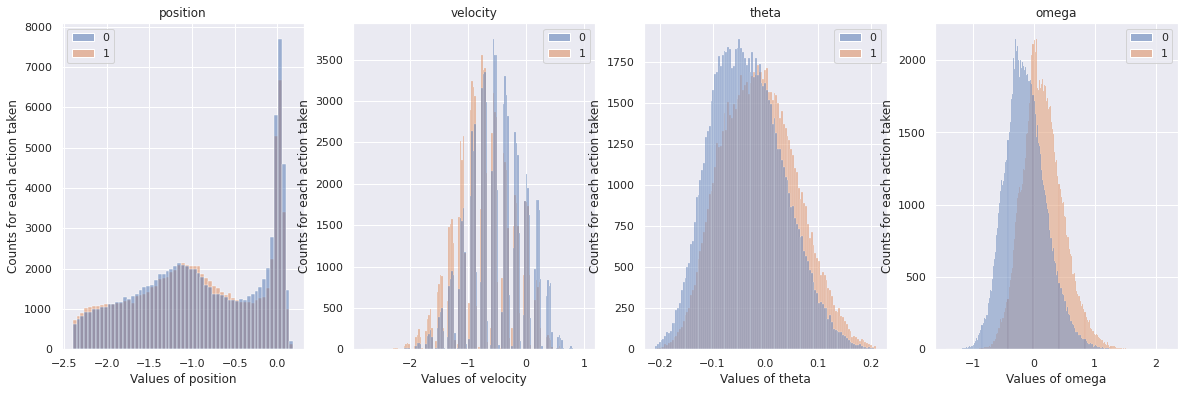

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
names = ['position', 'velocity', 'theta', 'omega']
for idx, ax in enumerate(axs):
    values = all_states[:, idx].numpy()
    sns.histplot(x=values, hue=all_actions, ax=ax)
    ax.set_title(names[idx])
    ax.set_xlabel(f'Values of {names[idx]}')
    ax.set_ylabel("Counts for each action taken")

### State vs saliency

In [14]:
import pandas as pd
pd.DataFrame(all_states.numpy(), columns=['position', 'velocity', 'theta', 'omega']).agg(['min', 'max'])

,position,velocity,theta,omega
min,-2.399977,-2.273626,-0.209193,-1.221838
max,0.167414,0.808388,0.207591,1.878726


In [15]:
cols = ["position", "velocity", "theta", "omega"]
df = pd.DataFrame(
    torch.concat([all_states, delta_out], dim=1).numpy(),
    columns=cols + [x + "_sal" for x in cols],
)

for col in cols:
    df[col+'_bin'] = pd.qcut(df[col], 4)


df.head()

,position,velocity,theta,omega,position_sal,velocity_sal,theta_sal,omega_sal,position_bin,velocity_bin,theta_bin,omega_bin
0,-0.023839,0.016120,-0.002548,0.020568,-0.971163,3.348012,7.510213,8.514269,"(-0.163, 0.167]","(-0.228, 0.808]","(-0.0266, 0.025]","(-0.00737, 0.241]"
1,-0.023517,0.211279,-0.002136,-0.272918,-0.692926,3.300678,7.389601,8.798882,"(-0.163, 0.167]","(-0.228, 0.808]","(-0.0266, 0.025]","(-1.2229999999999999, -0.246]"
2,-0.019291,0.406431,-0.007595,-0.566274,-1.046731,2.854181,6.643284,7.544614,"(-0.163, 0.167]","(-0.228, 0.808]","(-0.0266, 0.025]","(-1.2229999999999999, -0.246]"
3,-0.011163,0.601659,-0.018920,-0.861340,-0.900238,2.802421,6.126661,6.851016,"(-0.163, 0.167]","(-0.228, 0.808]","(-0.0266, 0.025]","(-1.2229999999999999, -0.246]"
4,0.000870,0.406800,-0.036147,-0.574665,-1.072706,2.885950,6.976521,7.733358,"(-0.163, 0.167]","(-0.228, 0.808]","(-0.0743, -0.0266]","(-1.2229999999999999, -0.246]"


In [16]:
df.position_sal.describe()

count    18911.000000
mean        -0.550934
std          0.421149
min         -1.627743
25%         -0.930538
50%         -0.554507
75%         -0.180346
max          0.487882
Name: position_sal, dtype: float64

Note that actor output is logit(action=1) (before sigmoid)

- Position:  
   +ve perturbation = moving cart to right (keeping theta, omega, velocity constant)  
   Negative saliency in all the plots => actor wants to keep the cart at the center by moving it left

- Velocity is hard to explain on saliency

- For theta and omega:
 saliency is always positive
    - if theta is increases then actor wants to move cart to right
    - if theta decreases (large negative value) then actor wants to move cart to left




In [22]:
list(df)

['position',
 'velocity',
 'theta',
 'omega',
 'position_sal',
 'velocity_sal',
 'theta_sal',
 'omega_sal',
 'position_bin',
 'velocity_bin',
 'theta_bin',
 'omega_bin']

In [29]:
df[["position_sal", "velocity_sal", "theta_sal", "omega_sal"]].mean().reset_index().rename(columns={
    'index': 'feature',
    0: 'saliency_mean'
})


,feature,saliency_mean
0,position_sal,-0.550932
1,velocity_sal,3.336646
2,theta_sal,6.763314
3,omega_sal,6.630259


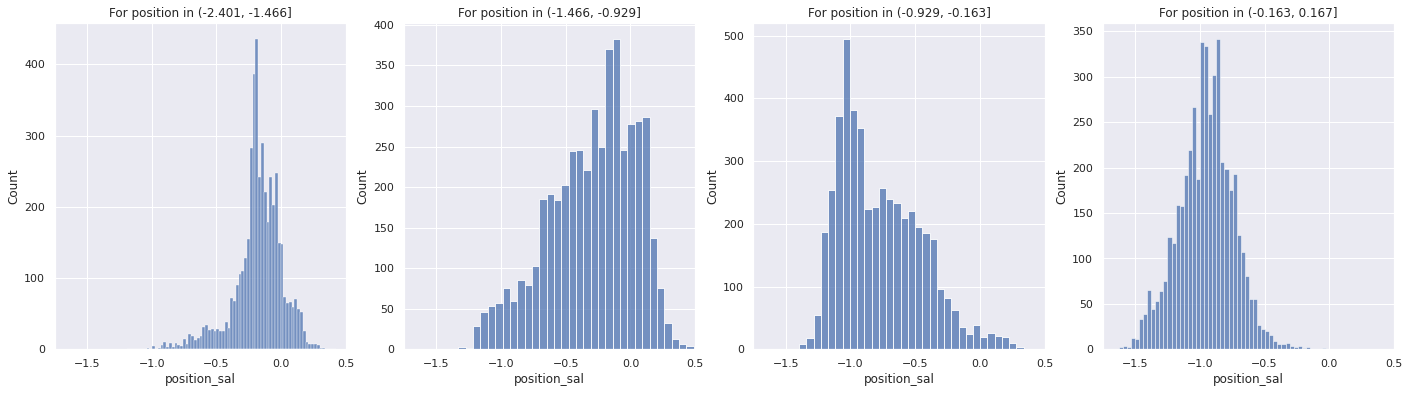

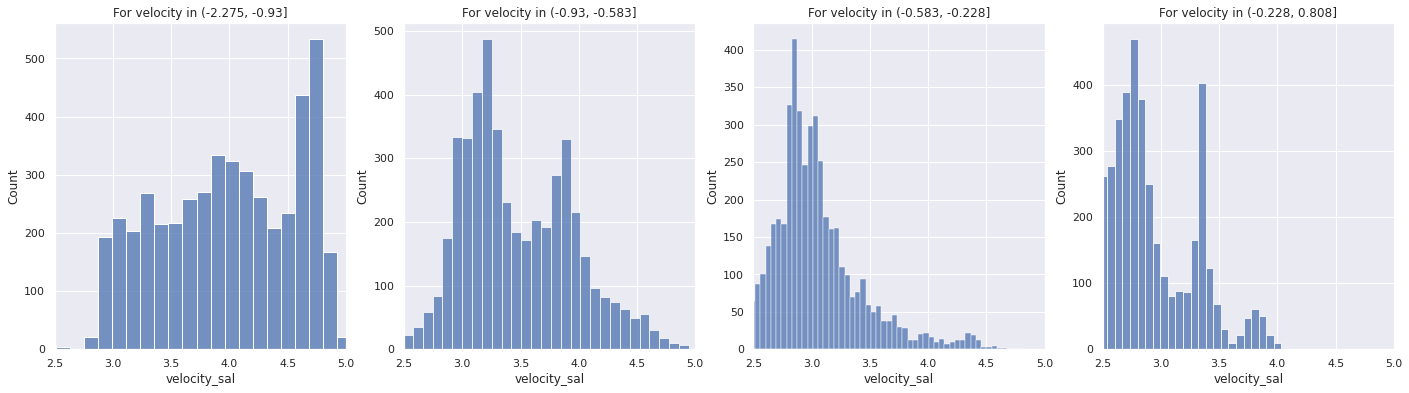

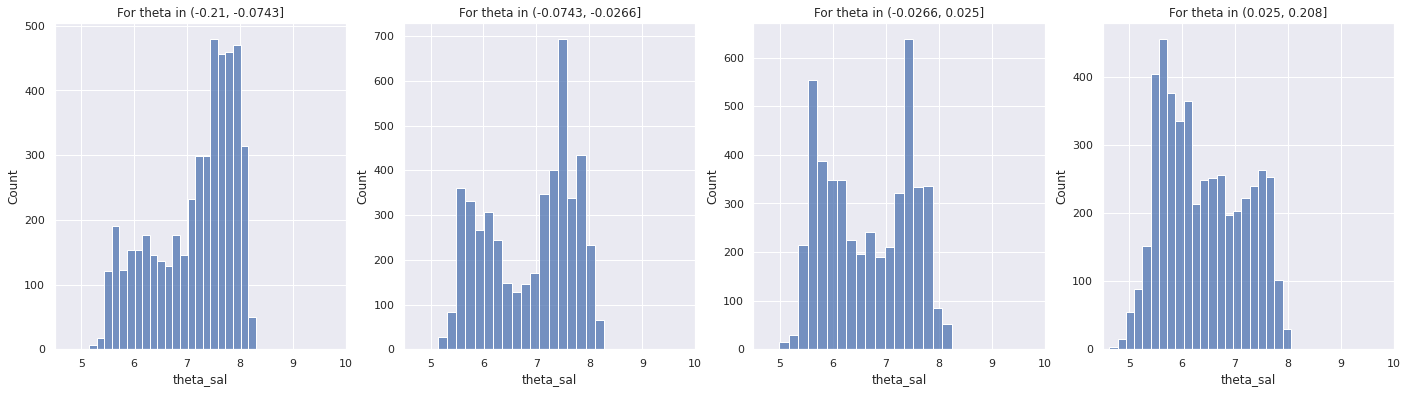

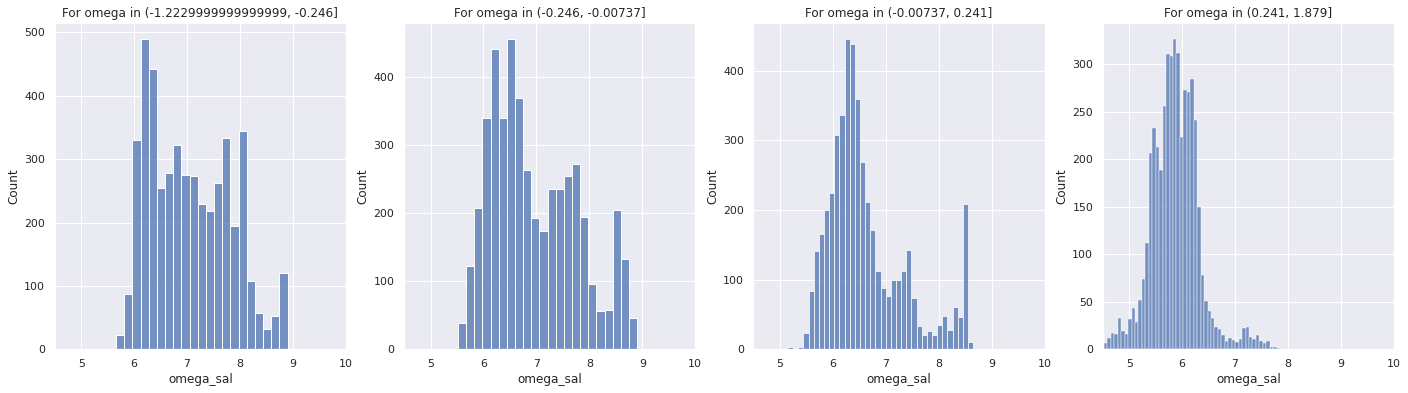

In [20]:
lim_dict = {
    'position': [-1.75, 0.5],
    'velocity': [2.5, 5],
    'theta': [4.5, 10],
    'omega': [4.5, 10],
}
for col in cols:
    groups = df.groupby(col+'_bin')
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    for (col_bin, group), ax in zip(groups, axs):
        sns.histplot(data=group, x=col+'_sal', ax=ax)
        ax.set_title(f'For {col} in {col_bin}')
        ax.set_xlim(*lim_dict[col])
    plt.show()

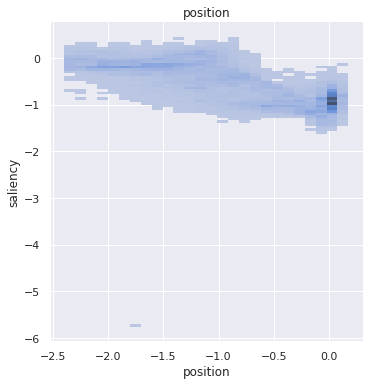

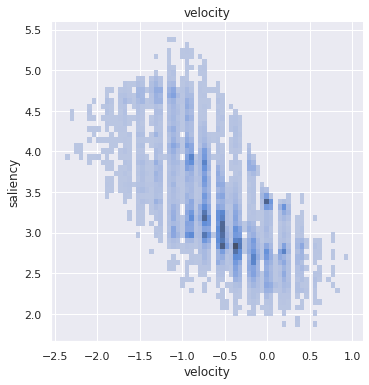

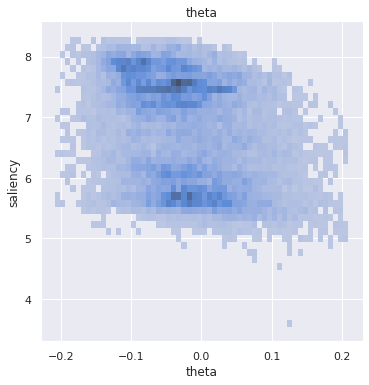

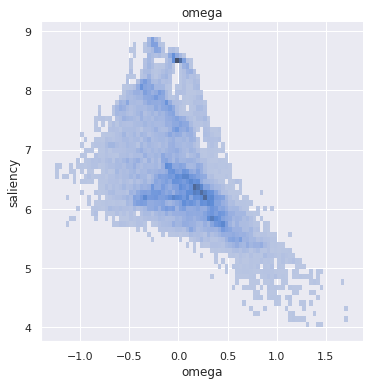

In [27]:
names = ['position', 'velocity', 'theta', 'omega']
for idx, ax in enumerate(axs):
    values = all_states[:, idx].numpy()
    saliencies = delta_out[:, idx].numpy()
    sns.displot(x=values, y=saliencies)
    plt.xlabel(names[idx])
    plt.ylabel('saliency')
    plt.title(names[idx])